In [2]:
# some necessary imports
import os
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt


In [3]:
train_df = pd.read_csv('../../datasets/train-balanced-sarcasm.csv')

In [4]:
train_df.head()

,label,comment,author,subreddit,score,ups,downs,date,created_utc,parent_comment
0,0,NC and NH.,Trumpbart,politics,2,-1,-1,2016-10,2016-10-16 23:55:23,"Yeah, I get that argument. At this point, I'd ..."
1,0,You do know west teams play against west teams...,Shbshb906,nba,-4,-1,-1,2016-11,2016-11-01 00:24:10,The blazers and Mavericks (The wests 5 and 6 s...
2,0,"They were underdogs earlier today, but since G...",Creepeth,nfl,3,3,0,2016-09,2016-09-22 21:45:37,They're favored to win.
3,0,"This meme isn't funny none of the ""new york ni...",icebrotha,BlackPeopleTwitter,-8,-1,-1,2016-10,2016-10-18 21:03:47,deadass don't kill my buzz
4,0,I could use one of those tools.,cush2push,MaddenUltimateTeam,6,-1,-1,2016-12,2016-12-30 17:00:13,Yep can confirm I saw the tool they use for th...


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1010826 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010826 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010826 non-null  object
 3   subreddit       1010826 non-null  object
 4   score           1010826 non-null  int64 
 5   ups             1010826 non-null  int64 
 6   downs           1010826 non-null  int64 
 7   date            1010826 non-null  object
 8   created_utc     1010826 non-null  object
 9   parent_comment  1010826 non-null  object
dtypes: int64(4), object(6)
memory usage: 77.1+ MB


In [10]:
train_df.dropna(subset=['comment'], inplace=True)

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1010773 entries, 0 to 1010825
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   label           1010773 non-null  int64 
 1   comment         1010773 non-null  object
 2   author          1010773 non-null  object
 3   subreddit       1010773 non-null  object
 4   score           1010773 non-null  int64 
 5   ups             1010773 non-null  int64 
 6   downs           1010773 non-null  int64 
 7   date            1010773 non-null  object
 8   created_utc     1010773 non-null  object
 9   parent_comment  1010773 non-null  object
dtypes: int64(4), object(6)
memory usage: 84.8+ MB


In [12]:
train_df.label.value_counts()

0    505405
1    505368
Name: label, dtype: int64

In [13]:
train_texts, valid_texts, y_train, y_valid = train_test_split(train_df.comment, train_df.label,
                                                              random_state=17)

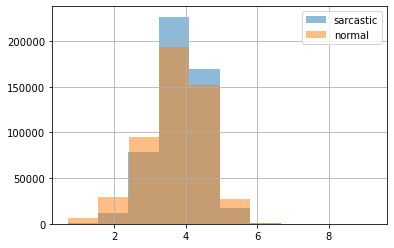

In [29]:
train_df.loc[train_df['label'] == 1, 'comment'].str.len().apply(np.log1p).hist(label='sarcastic', alpha=.5)
train_df.loc[train_df['label'] == 0, 'comment'].str.len().apply(np.log1p).hist(label='normal', alpha=.5)
plt.legend()

In [30]:
from wordcloud import WordCloud, STOPWORDS

In [31]:
wordcloud = WordCloud(background_color='black', stopwords=STOPWORDS,
                      random_state=17, width=800, height=400)

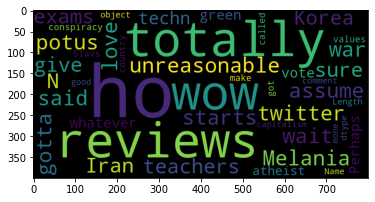

In [32]:
wordcloud.generate(str(train_df.loc[train_df['label'] == 1, 'comment']))
plt.imshow(wordcloud)

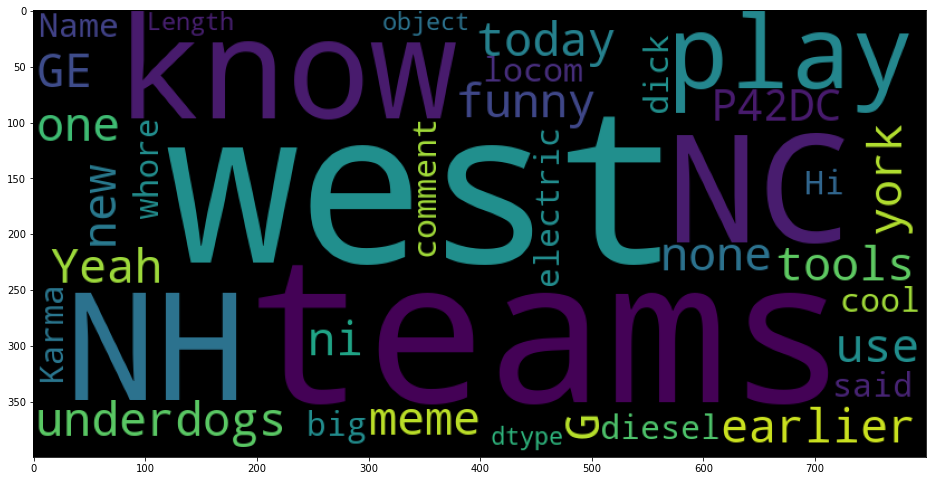

In [34]:
plt.figure(figsize=(16, 9))
wordcloud.generate(str(train_df.loc[train_df.label == 0, 'comment']))
plt.imshow(wordcloud)

In [40]:
sub_df = train_df.groupby('subreddit', as_index=False)['label'].agg([np.size, np.mean, np.sum])
sub_df.sort_values(by='sum', ascending=False)

,size,mean,sum
subreddit,,,
AskReddit,65674,0.401453,26365
politics,39493,0.605348,23907
worldnews,26376,0.642516,16947
leagueoflegends,21034,0.542312,11407
pcmasterrace,18987,0.566651,10759
...,...,...,...
Tgifs,1,0.000000,0
TexasCHL,1,0.000000,0
TerrariaExchange,1,0.000000,0


In [41]:
sub_df[sub_df['size'] > 1000].sort_values(by='mean', ascending=False).head(10)

,size,mean,sum
subreddit,,,
creepyPMs,5466,0.784303,4287
MensRights,3355,0.680775,2284
ShitRedditSays,1284,0.661994,850
worldnews,26376,0.642516,16947
Libertarian,2562,0.640125,1640
atheism,7377,0.639555,4718
Conservative,1881,0.639553,1203
TwoXChromosomes,1560,0.632692,987
fatlogic,2356,0.623090,1468


In [42]:
tf_idf = TfidfVectorizer(ngram_range=(1, 3), max_features=50000, min_df=2)
logit = LogisticRegression(C=1, n_jobs=-1, solver='lbfgs', random_state=17)

tfidf_logit_pipeline = Pipeline([('tf_idf', tf_idf),
                                 ('logit', logit)])

In [43]:
tfidf_logit_pipeline.fit(train_texts, y_train)

Pipeline(steps=[('tf_idf',
                 TfidfVectorizer(max_features=50000, min_df=2,
                                 ngram_range=(1, 3))),
                ('logit', LogisticRegression(C=1, n_jobs=-1, random_state=17))])

In [44]:
valid_pred = tfidf_logit_pipeline.predict(valid_texts)

In [45]:
accuracy_score(y_valid, valid_pred)

0.7218374793228173

In [46]:
def plot_confusion_matrix(actual, predicted, classes,
                          normalize=False,
                          title='Confusion matrix', figsize=(7,7),
                          cmap=plt.cm.Blues, path_to_save_fig=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(actual, predicted).T
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Predicted label')
    plt.xlabel('True label')

    if path_to_save_fig:
        plt.savefig(path_to_save_fig, dpi=300, bbox_inches='tight')

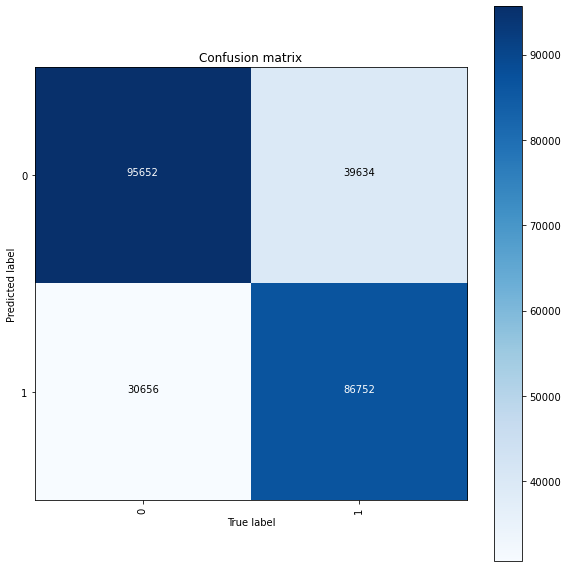

In [47]:
plot_confusion_matrix(y_valid, valid_pred,
                      tfidf_logit_pipeline.named_steps['logit'].classes_, figsize=(8, 8))

In [48]:
import eli5
eli5.show_weights(estimator=tfidf_logit_pipeline.named_steps['logit'],
                  vec=tfidf_logit_pipeline.named_steps['tf_idf'])

Weight?,Feature
+9.058,yes because
+7.406,obviously
+7.308,clearly
+7.295,yeah because
+6.759,totally
+6.145,because
+5.668,don you know
+5.417,how dare
+5.360,right because
+5.170,good thing


In [50]:
subreddits = train_df['subreddit']
train_subreddits, valid_subreddits = train_test_split(subreddits, random_state=17)

In [51]:
train_subreddits

827869    electronic_cigarette
800568               AskReddit
506459                   funny
372707                   DotA2
548483               AskReddit
                  ...         
828759                    news
491940         leagueoflegends
297109               2007scape
589061             Philippines
993950         leagueoflegends
Name: subreddit, Length: 758079, dtype: object

In [52]:
tf_idf_texts = TfidfVectorizer(ngram_range=(1, 3), max_features=50000, min_df=2)
tf_idf_subreddits = TfidfVectorizer(ngram_range=(1, 2))

In [53]:
X_train_texts = tf_idf_texts.fit_transform(train_texts)
X_valid_texts = tf_idf_texts.transform(valid_texts)


In [54]:
X_train_texts.shape, X_valid_texts.shape

((758079, 50000), (252694, 50000))

In [55]:
X_train_subreddits = tf_idf_subreddits.fit_transform(train_subreddits)
X_valid_subreddits = tf_idf_subreddits.transform(valid_subreddits)

In [56]:
from scipy.sparse import hstack
X_train = hstack([X_train_texts, X_train_subreddits])
X_valid = hstack([X_valid_texts, X_valid_subreddits])

In [57]:
logit.fit(X_train, y_train)

LogisticRegression(C=1, n_jobs=-1, random_state=17)

In [58]:
valid_pred = logit.predict(X_valid)

In [59]:
accuracy_score(y_valid, valid_pred)

0.725276421284241

In [65]:
num_words = train_df["comment"].apply(lambda x: len(str(x).split()))

train_num_words, valid_num_words = train_test_split(num_words, random_state=17)


In [76]:
from scipy.sparse import coo_matrix
train_num_words_matrix = coo_matrix(train_num_words).T

In [78]:
X_train = hstack([X_train, train_num_words_matrix])


In [81]:
valid_num_words_matrix = coo_matrix(valid_num_words).T

In [82]:
X_valid = hstack([X_valid, valid_num_words_matrix])


In [83]:
logit.fit(X_train, y_train)

LogisticRegression(C=1, n_jobs=-1, random_state=17)

In [84]:
valid_pred = logit.predict(X_valid)

In [85]:
accuracy_score(y_valid, valid_pred)

0.6743689996596675